In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
N = 1000  # 何個の要素に分けるか
# 切削係数
K_tc = 1000
K_rc = 700
K_ac = 100
# 切れ刃と被削材の摩擦力係数
K_te = 10
K_re = 5
K_ae = 0

D = 2  # 工具直径（㎜）
num_blades = 2  # 刃数
twist_angle = 30  # ねじれ角（degree）
axial_depth = 2  # 軸方向切り込み深さ（㎜）
fz = 0.5  # 一刃あたりの送り量（mm / 刃）→ 次の刃が来るまでの横移動量
theta_0 = 0  # エンドミル先端の刃の初期角度（degree）
processing_time = 0.2  # 加工時間（s）
rotation_speed = 6000  # エンドミルの回転速度（rpm）
feed_speed = 0.25  # エンドミルの送り速度（㎜/s）
# 工具半径 (mm)
R = D / 2
# ねじれ角の変化率
twist_angle_rate = np.pi * np.tan(np.radians(twist_angle)) / (2 * R)
# 微小部分の厚み
dz = axial_depth / N


# 微小要素におけるx, y, z方向それぞれの切削力を計算
def calc_cutting_force(theta_list):
    F_xj = F_yj = F_zj = 0
    for theta in theta_list:
        F_xj += (
            -K_te * np.cos(theta)
            - K_tc * fz * np.sin(theta) * np.cos(theta)
            - K_re * np.sin(theta)
            - K_rc * fz * (np.sin(theta) ** 2)
        ) * dz
        F_yj += (
            K_te * np.sin(theta)
            + K_tc * fz * (np.sin(theta) ** 2)
            - K_re * np.cos(theta)
            - K_rc * fz * np.sin(theta) * np.cos(theta)
        ) * dz
        F_zj += (-K_ae - K_ac * fz * np.sin(theta)) * dz
    return F_xj, F_yj, F_zj


# 切り込み深さ全体におけるx, y, z方向それぞれの切削力を計算
def calc_sum_cutting_force(theta_0):
    F_x = F_y = F_z = 0
    for i in range(1, N + 1):
        z = axial_depth * i / N
        angle_radian = twist_angle_rate * z + np.radians(theta_0)
        angle_degree = np.degrees(angle_radian)
        angle_list_degree = [angle_degree % 360]
        for _ in range(num_blades - 1):
            angle_degree = angle_degree + 360 / num_blades
            angle_list_degree.append(angle_degree % 360)
        hitting_angle_list_degree = []
        for angle in angle_list_degree:
            if angle >= 0 and angle <= 180:
                hitting_angle_list_degree.append(angle)
        hitting_angle_list_radian = np.radians(hitting_angle_list_degree)
        temp_Fx, temp_Fy, temp_Fz = calc_cutting_force(hitting_angle_list_radian)
        F_x += temp_Fx
        F_y += temp_Fy
        F_z += temp_Fz
    return F_x, F_y, F_z


time = []
Fx = []
Fy = []
Fz = []

time_T = 10  # s
time_N = 100000

h = float(time_T / time_N)

for i in range(1000):
    t = i * h
    time.append(t)
    theta_0 += np.degrees((rotation_speed / 60) * h * np.pi * 2)
    theta_0 %= 360
    F_x, F_y, F_z = calc_sum_cutting_force(theta_0)
    Fx.append(F_x)
    Fy.append(F_y)
    Fz.append(F_z)
    if i % 100 == 0:
        print("iteration =", i, "time =", t)


iteration = 0 time = 0.0
iteration = 100 time = 0.01
iteration = 200 time = 0.02
iteration = 300 time = 0.030000000000000002
iteration = 400 time = 0.04
iteration = 500 time = 0.05
iteration = 600 time = 0.060000000000000005
iteration = 700 time = 0.07
iteration = 800 time = 0.08
iteration = 900 time = 0.09000000000000001


In [3]:
len(Fx)

1000

iteration= 0 time= 0.0
iteration= 100 time= 0.01
iteration= 200 time= 0.02
iteration= 300 time= 0.030000000000000002
iteration= 400 time= 0.04
iteration= 500 time= 0.05
iteration= 600 time= 0.060000000000000005
iteration= 700 time= 0.07
iteration= 800 time= 0.08
iteration= 900 time= 0.09000000000000001


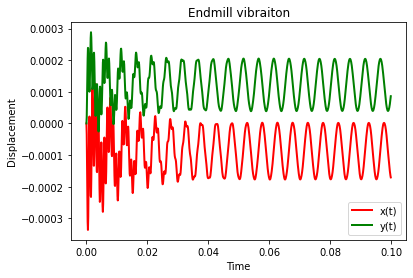

In [4]:
N = 100000  # サンプル数
T = 10  # 時間幅


def f1(u, v):
    return v


def f2(u, v, fx, fy):
    M_inv = np.linalg.inv(M)

    F = np.zeros(len(M))
    F[0] = fx
    F[1] = fy

    return np.dot(M_inv, F) - np.dot(np.dot(C, M_inv), v) - np.dot(np.dot(K, M_inv), u)


def impulse(A=1):
    impulse = np.zeros(N)
    impulse[1] = A
    return impulse


noforce = np.zeros(N)


def sim(u0, v0, fx=noforce, fy=noforce):
    h = float(T / N)
    u, v = u0, v0

    time = []
    x_position = []
    x_velocity = []
    y_position = []
    y_velocity = []

    for i in range(1000):
        t = i * h

        time.append(t)
        x_position.append(u[0])
        x_velocity.append(v[0])

        y_position.append(u[1])
        y_velocity.append(v[1])

        if i % 100 == 0:
            print("iteration=", i, "time=", t)

        k11 = f1(u, v)
        k12 = f2(u, v, fx[i], fy[i])

        k21 = f1(u + k11 * (h / 2), v + k12 * (h / 2))
        k22 = f2(u + k11 * (h / 2), v + k12 * (h / 2), fx[i], fy[i])

        k31 = f1(u + k21 * (h / 2), v + k22 * (h / 2))
        k32 = f2(u + k21 * (h / 2), v + k22 * (h / 2), fx[i], fy[i])

        k41 = f1(u + k31 * h, v + k32 * h)
        k42 = f2(u + k31 * h, v + k32 * h, fx[i], fy[i])

        u += (k11 + 2 * k21 + 2 * k31 + k41) * h / 6
        v += (k12 + 2 * k22 + 2 * k32 + k42) * h / 6

    return time, x_position, y_position


# M = np.array([[100, 0], [0, 50]])
# C = np.array([[100, -50], [-50, 50]])
# K = np.array([[6.0e4, -1.0e4], [-1.0e4, 1.0e4]])

# u0 = np.zeros(len(M))
# v0 = np.zeros(len(M))

# impulse = impulse()
# time, x_position, y_position = sim(u0, v0, fx=impulse)

# plt.plot(time, y_position, color="red", linewidth=2, label="y(t)")
# plt.title("Endmill vibraiton")
# plt.xlabel("Time")
# plt.ylabel("Displacement")
# plt.legend()
# plt.show()

M = np.array([[0.095, -0.003], [-0.001, 0.102]])
C = np.array([[16.45, -1.82], [-0.98, 18.40]])
K = np.array([[3.9e6, -1.4e5], [-2.0e4, 4.2e6]])


u0 = np.array([0.0, 0.0])
v0 = np.array([0.0, 0.0])

time, x_position, y_position = sim(u0, v0, fx=Fx, fy=Fy)

plt.plot(time, x_position, color="red", linewidth=2, label="x(t)")
plt.plot(time, y_position, color="green", linewidth=2, label="y(t)")
plt.title("Endmill vibraiton")
plt.xlabel("Time")
plt.ylabel("Displacement")
plt.legend()
plt.show()